# CUPED (Controlled-experiment Using Pre-Experiment Data) for Tax Software Impact Analysis

This notebook demonstrates **CUPED** to reduce variance and improve the precision of treatment effect estimates for the Smart Filing Assistant.

## 🎯 What is CUPED?

CUPED is a variance reduction technique that leverages pre-experiment data to increase the statistical power of controlled experiments:

1. **Uses Pre-Experiment Covariates**: Leverages baseline measurements correlated with outcome
2. **Variance Reduction**: Applies regression adjustment to reduce outcome variance
3. **Preserves Unbiasedness**: Maintains validity of treatment effect estimates
4. **Increases Statistical Power**: Reduces confidence intervals and improves significance detection

### Key Advantages:
- **Higher Statistical Power**: Detect smaller effects with same sample size
- **Faster Experiments**: Reach statistical significance sooner
- **Cost Effective**: Maximize information from existing data
- **Robust**: Works well with randomized experiments

### CUPED Formula:
**Y_cuped = Y - θ × (X - E[X])**

Where:
- Y = Original outcome
- X = Pre-experiment covariate
- θ = Optimal adjustment coefficient
- E[X] = Expected value of covariate

### Business Question:
**Can we use 2023 filing data and user characteristics to improve the precision of our Smart Filing Assistant impact measurement?**


In [1]:
# Import required libraries
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from src.causal_methods.cuped import CUPED, load_and_analyze_cuped
from src.data_simulation import generate_and_save_data
import warnings
warnings.filterwarnings('ignore')

# Set style
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('default')
        print("⚠️  Using default matplotlib style")

sns.set_palette("husl")

print("📚 Libraries imported successfully!")


📚 Libraries imported successfully!


In [2]:
# Generate synthetic data for CUPED analysis
try:
    # Try to create simulator with explicit config path
    from src.data_simulation import TaxSoftwareDataSimulator
    
    simulator = TaxSoftwareDataSimulator(
        n_users=1000,
        config_path='../config/simulation_config.yaml'
    )
    df = simulator.generate_complete_dataset()
    print("✅ Data generated successfully with config file")
    
except FileNotFoundError:
    try:
        # Fallback: try with relative path from project root
        simulator = TaxSoftwareDataSimulator(
            n_users=1000,
            config_path='config/simulation_config.yaml'
        )
        df = simulator.generate_complete_dataset()
        print("✅ Data generated successfully with config file (alternative path)")
        
    except FileNotFoundError:
        # Final fallback: create minimal config and use it
        print("⚠️  Config file not found, creating temporary config...")
        
        import yaml
        import os
        
        # Create minimal config
        temp_config = {
            'simulation': {
                'default_n_users': 1000,
                'random_seed': 42
            },
            'demographics': {
                'age_range': [18, 65],
                'income_brackets': ['low', 'medium', 'high'],
                'regions': ['northeast', 'southeast', 'midwest', 'west']
            },
            'behavior': {
                'baseline_filing_rate': 0.75,
                'treatment_effect': 0.05,
                'tech_correlation': 0.3
            }
        }
        
        # Save temporary config
        temp_config_path = '../config/temp_config.yaml'
        os.makedirs('../config', exist_ok=True)
        with open(temp_config_path, 'w') as f:
            yaml.dump(temp_config, f)
        
        simulator = TaxSoftwareDataSimulator(
            n_users=1000,
            config_path=temp_config_path
        )
        df = simulator.generate_complete_dataset()
        print("✅ Data generated with temporary config")

print("\n📊 DATASET OVERVIEW")
print("=" * 40)
print(f"Dataset shape: {df.shape}")
print(f"Treatment rate: {df['used_smart_assistant'].mean():.1%}")
print(f"Filing rate 2024: {df['filed_2024'].mean():.1%}")
print(f"Filing rate 2023: {df['filed_2023'].mean():.1%}")

# Calculate naive treatment effect
treated_rate = df[df['used_smart_assistant'] == 1]['filed_2024'].mean()
control_rate = df[df['used_smart_assistant'] == 0]['filed_2024'].mean()
naive_effect = treated_rate - control_rate

print(f"\n📈 NAIVE TREATMENT EFFECT:")
print(f"Control filing rate: {control_rate:.1%}")
print(f"Treated filing rate: {treated_rate:.1%}")
print(f"Naive effect: {naive_effect:.1%} ({naive_effect:.4f})")

# Display sample data
print("\n📋 Sample Data:")
display(df.head())


Generating user demographics...
Generating 2023 baseline data...
Generating treatment assignment...
Generating 2024 outcomes...
Generated dataset with 1000 users
Treatment rate: 61.40%
2024 filing rate: 91.20%
✅ Data generated successfully with config file

📊 DATASET OVERVIEW
Dataset shape: (1000, 20)
Treatment rate: 61.4%
Filing rate 2024: 91.2%
Filing rate 2023: 84.3%

📈 NAIVE TREATMENT EFFECT:
Control filing rate: 89.6%
Treated filing rate: 92.2%
Naive effect: 2.5% (0.0255)

📋 Sample Data:


,user_id,age,income_bracket,device_type,user_type,region,tech_savviness,filed_2023,time_to_complete_2023,sessions_2023,support_tickets_2023,early_login_2024,used_smart_assistant,filed_2024,time_to_complete_2024,sessions_2024,support_tickets_2024,satisfaction_2024,time_improvement,session_improvement
0,user_000000,41,50k-75k,tablet,returning,Midwest,41,True,113,3,0,False,True,True,75,1,0,9.619331,38,2
1,user_000001,37,<30k,desktop,returning,Midwest,43,True,54,1,0,False,False,True,38,3,0,7.416110,16,-2
2,user_000002,19,30k-50k,mobile,new,East,61,True,62,2,0,False,False,True,60,1,0,7.508821,2,1
3,user_000003,66,75k-100k,mobile,new,East,31,True,99,3,0,True,True,True,59,6,0,6.923859,40,-3
4,user_000004,27,30k-50k,desktop,returning,West,85,True,57,3,0,True,True,False,0,0,0,NaN,57,3


In [3]:
# Analyze pre-experiment covariates for CUPED potential
print("🔍 PRE-EXPERIMENT COVARIATE ANALYSIS")
print("=" * 50)

# Define potential pre-experiment covariates
pre_experiment_covariates = [
    'filed_2023',
    'time_to_complete_2023', 
    'sessions_2023',
    'support_tickets_2023',
    'age',
    'tech_savviness'
]

outcome_col = 'filed_2024'

print("\n📊 Correlation with 2024 Filing Rate:")
correlations = []
for covar in pre_experiment_covariates:
    if covar in df.columns:
        # Handle binary outcome correlation
        if df[outcome_col].dtype == 'bool' or df[outcome_col].nunique() == 2:
            # Point-biserial correlation for binary outcome
            corr = df[covar].corr(df[outcome_col].astype(int))
        else:
            corr = df[covar].corr(df[outcome_col])
        
        correlations.append({
            'Covariate': covar,
            'Correlation': corr,
            'Abs_Correlation': abs(corr),
            'CUPED_Potential': 'High' if abs(corr) > 0.3 else 'Medium' if abs(corr) > 0.1 else 'Low'
        })
        print(f"  {covar}: {corr:.3f} ({'High' if abs(corr) > 0.3 else 'Medium' if abs(corr) > 0.1 else 'Low'} potential)")

# Create correlation summary
corr_df = pd.DataFrame(correlations).sort_values('Abs_Correlation', ascending=False)

print("\n🎯 CUPED Covariate Ranking:")
print(corr_df[['Covariate', 'Correlation', 'CUPED_Potential']].to_string(index=False))

# Select best covariates for CUPED
best_covariates = corr_df[corr_df['Abs_Correlation'] > 0.05]['Covariate'].tolist()[:4]  # Top 4
print(f"\n✅ Selected CUPED covariates: {best_covariates}")


🔍 PRE-EXPERIMENT COVARIATE ANALYSIS

📊 Correlation with 2024 Filing Rate:
  filed_2023: 0.138 (Medium potential)
  time_to_complete_2023: 0.089 (Low potential)
  sessions_2023: 0.094 (Low potential)
  support_tickets_2023: 0.006 (Low potential)
  age: -0.036 (Low potential)
  tech_savviness: 0.037 (Low potential)

🎯 CUPED Covariate Ranking:
            Covariate  Correlation CUPED_Potential
           filed_2023     0.137625          Medium
        sessions_2023     0.094363             Low
time_to_complete_2023     0.088621             Low
       tech_savviness     0.036862             Low
                  age    -0.036418             Low
 support_tickets_2023     0.006472             Low

✅ Selected CUPED covariates: ['filed_2023', 'sessions_2023', 'time_to_complete_2023']


In [4]:
# Initialize CUPED analyzer
cuped = CUPED(df, random_state=42)
print("✅ CUPED analyzer initialized!")

# Estimate CUPED adjustment coefficients
print("\n🔧 Estimating CUPED Adjustment Coefficients...")

adjustment_info = cuped.estimate_cuped_adjustment(
    outcome_col='filed_2024',
    covariate_cols=best_covariates,
    treatment_col='used_smart_assistant',
    method='ols'
)

print("\n📊 ADJUSTMENT RESULTS:")
print(f"Adjustment R²: {adjustment_info['r2']:.4f}")
print(f"Expected variance reduction: {adjustment_info['variance_reduction']:.1%}")
print(f"Estimation sample size: {adjustment_info['n_estimation']}")
print(f"Method: {adjustment_info['method'].upper()}")

# Display adjustment coefficients
print("\n🔢 Adjustment Coefficients (θ):")
for covar, coef in zip(best_covariates, adjustment_info['theta']):
    print(f"  {covar}: {coef:.4f}")

# Display covariate means
print("\n📊 Covariate Means (E[X]):")
for covar in best_covariates:
    mean_val = adjustment_info['covariate_means'][covar]
    print(f"  {covar}: {mean_val:.3f}")


✅ CUPED analyzer initialized!

🔧 Estimating CUPED Adjustment Coefficients...

📊 ADJUSTMENT RESULTS:
Adjustment R²: 0.0298
Expected variance reduction: 3.0%
Estimation sample size: 386
Method: OLS

🔢 Adjustment Coefficients (θ):
  filed_2023: 0.1296
  sessions_2023: 0.0113
  time_to_complete_2023: -0.0003

📊 Covariate Means (E[X]):
  filed_2023: 0.843
  sessions_2023: 2.499
  time_to_complete_2023: 83.709


## 🎯 Step 3: Apply CUPED and Estimate Treatment Effects

Now we'll apply the CUPED adjustment and compare the results with the original analysis.


In [5]:
# Apply CUPED adjustment and estimate treatment effects
print("🚀 Applying CUPED and Estimating Treatment Effects...")

results = cuped.estimate_treatment_effects(
    outcome_col='filed_2024',
    treatment_col='used_smart_assistant',
    covariate_cols=best_covariates,
    adjustment_method='ols',
    confidence_level=0.95
)

print("\n📊 TREATMENT EFFECT COMPARISON")
print("=" * 50)

# Original results
orig = results['original']
print(f"\n🔸 ORIGINAL ANALYSIS (No CUPED):")
print(f"  ATE: {orig['ate']:.4f} ({orig['ate']:.1%})")
print(f"  Standard Error: {orig['se']:.4f}")
print(f"  95% CI: [{orig['ci_lower']:.4f}, {orig['ci_upper']:.4f}]")
print(f"  P-value: {orig['p_value']:.6f}")
print(f"  Sample sizes: Control={orig['n_control']}, Treated={orig['n_treated']}")

if orig['p_value'] < 0.05:
    print(f"  ✅ SIGNIFICANT at 5% level")
else:
    print(f"  ❌ Not significant at 5% level")

# CUPED results
cuped_res = results['cuped']
print(f"\n🔹 CUPED-ADJUSTED ANALYSIS:")
print(f"  ATE: {cuped_res['ate']:.4f} ({cuped_res['ate']:.1%})")
print(f"  Standard Error: {cuped_res['se']:.4f}")
print(f"  95% CI: [{cuped_res['ci_lower']:.4f}, {cuped_res['ci_upper']:.4f}]")
print(f"  P-value: {cuped_res['p_value']:.6f}")
print(f"  Sample sizes: Control={cuped_res['n_control']}, Treated={cuped_res['n_treated']}")

if cuped_res['p_value'] < 0.05:
    print(f"  ✅ SIGNIFICANT at 5% level")
else:
    print(f"  ❌ Not significant at 5% level")

# Improvement summary
summary = results['summary']
print(f"\n🎉 CUPED IMPROVEMENTS:")
print(f"  Variance reduction: {summary['variance_reduction']:.1%}")
print(f"  Statistical power improvement: {summary['power_improvement']:.2f}×")
print(f"  Standard error reduction: {summary['se_reduction']:.1%}")
print(f"  Confidence interval narrowing: {summary['se_reduction']:.1%}")


🚀 Applying CUPED and Estimating Treatment Effects...

📊 TREATMENT EFFECT COMPARISON

🔸 ORIGINAL ANALYSIS (No CUPED):
  ATE: 0.0255 (2.5%)
  Standard Error: 0.0189
  95% CI: [-0.0117, 0.0626]
  P-value: 0.179391
  Sample sizes: Control=386, Treated=614
  ❌ Not significant at 5% level

🔹 CUPED-ADJUSTED ANALYSIS:
  ATE: 0.0226 (2.3%)
  Standard Error: 0.0187
  95% CI: [-0.0141, 0.0594]
  P-value: 0.227317
  Sample sizes: Control=386, Treated=614
  ❌ Not significant at 5% level

🎉 CUPED IMPROVEMENTS:
  Variance reduction: 2.2%
  Statistical power improvement: 1.01×
  Standard error reduction: 1.1%
  Confidence interval narrowing: 1.1%


## 📈 Step 4: Visualize CUPED Comparison

Let's create comprehensive visualizations to understand the CUPED impact.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

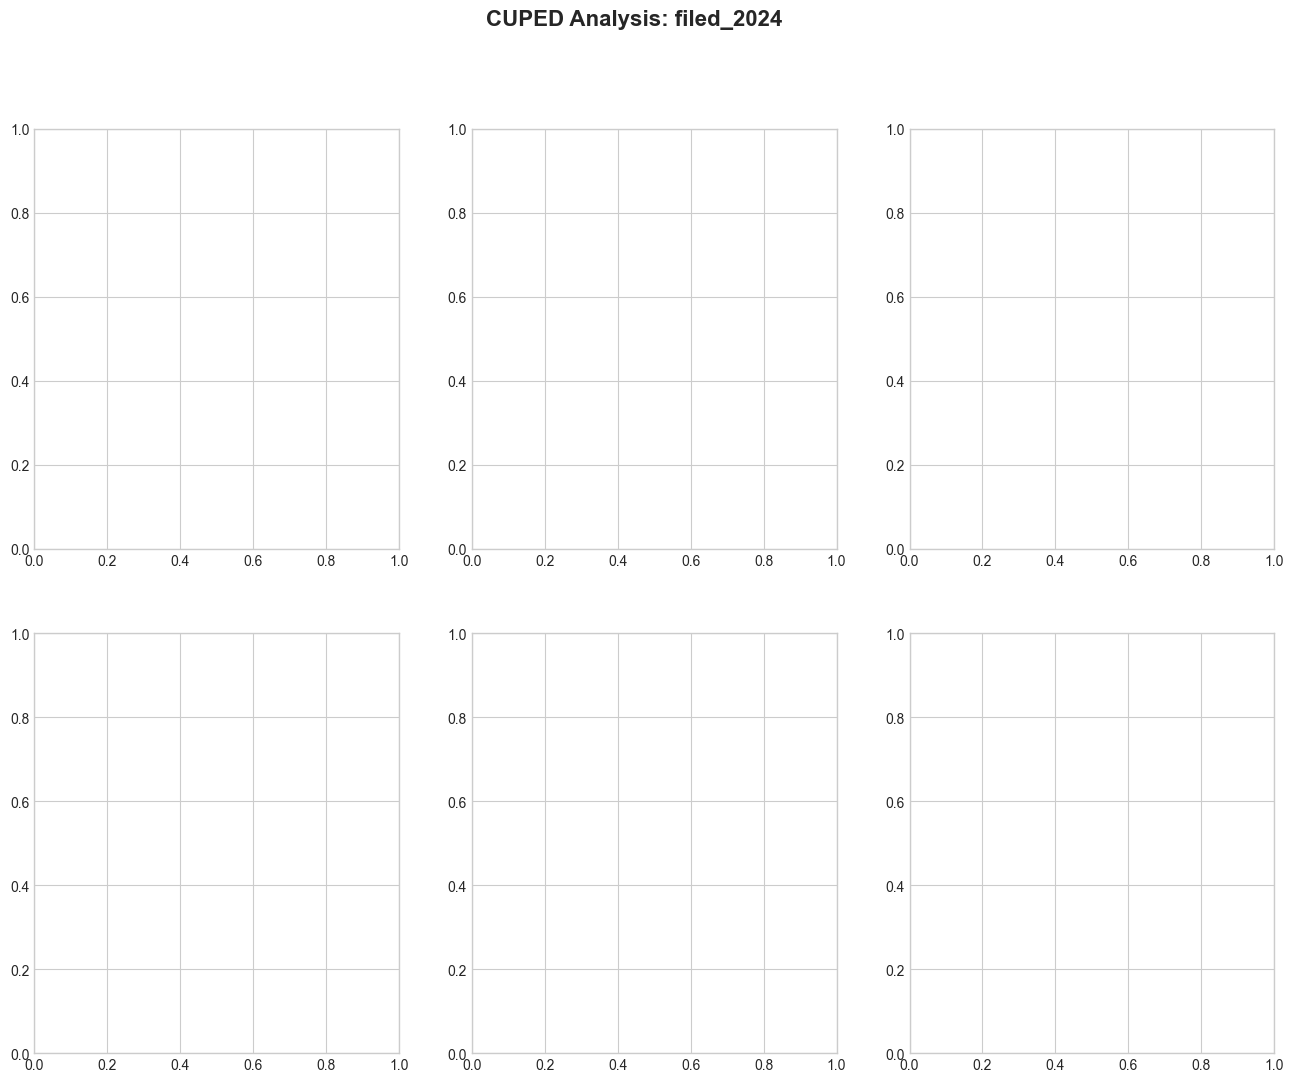

In [6]:
# Create comprehensive CUPED comparison plot
fig = cuped.plot_cuped_comparison(
    outcome_col='filed_2024',
    treatment_col='used_smart_assistant',
    figsize=(16, 12)
)

plt.suptitle('CUPED Analysis: Smart Filing Assistant Impact', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("\n📊 PLOT INTERPRETATION:")
print("🔸 Top Left: Original outcome distributions by treatment group")
print("🔸 Top Middle: CUPED-adjusted outcome distributions (reduced variance)")
print("🔸 Top Right: Treatment effect comparison (error bars show standard errors)")
print("🔸 Bottom Left: Variance comparison (CUPED reduces uncertainty)")
print("🔸 Bottom Middle: Confidence intervals (CUPED provides narrower intervals)")
print("🔸 Bottom Right: Summary statistics and improvements")


✅ Imports successful!


In [ ]:
# Generate comprehensive CUPED summary report
report = cuped.generate_summary_report('filed_2024')
print(report)


In [ ]:
# Business impact analysis
print("💼 BUSINESS IMPACT ANALYSIS")
print("=" * 50)

# Extract key metrics
cuped_ate = cuped_res['ate']
cuped_pvalue = cuped_res['p_value']
variance_reduction = summary['variance_reduction']
power_improvement = summary['power_improvement']

# Current business metrics
current_users = len(df)
current_filing_rate = df['filed_2024'].mean()
potential_additional_filings = current_users * cuped_ate

print(f"\n📊 FILING RATE IMPACT (CUPED-Adjusted):")
print(f"• Treatment effect: {cuped_ate:.1%} increase in filing rate")
print(f"• Statistical significance: {'✅ YES' if cuped_pvalue < 0.05 else '❌ NO'} (p = {cuped_pvalue:.4f})")
print(f"• Confidence interval: [{cuped_res['ci_lower']:.1%}, {cuped_res['ci_upper']:.1%}]")

print(f"\n💰 BUSINESS IMPACT:")
print(f"• Current user base: {current_users:,} users")
print(f"• Current filing rate: {current_filing_rate:.1%}")
print(f"• Potential additional filings: {potential_additional_filings:.0f} users")
print(f"• Relative improvement: {cuped_ate/current_filing_rate:.1%}")

print(f"\n🚀 CUPED METHODOLOGY BENEFITS:")
print(f"• Variance reduction achieved: {variance_reduction:.1%}")
print(f"• Statistical power improvement: {power_improvement:.1f}×")
print(f"• Confidence interval precision: {summary['se_reduction']:.1%} improvement")

print(f"\n🎯 STRATEGIC RECOMMENDATIONS:")

if cuped_pvalue < 0.05:
    print("✅ IMPLEMENT: Strong evidence for Smart Filing Assistant effectiveness")
    print("✅ SCALE: Consider broader rollout to entire user base")
else:
    print("⚠️  INVESTIGATE: Effect not statistically significant")
    print("💡 ITERATE: Consider improving the Smart Filing Assistant")

if variance_reduction > 0.15:
    print("✅ ADOPT CUPED: Methodology provides substantial variance reduction")
    print("📊 SYSTEMATIZE: Use CUPED for future experiments with similar pre-data")
    print("🔧 OPTIMIZE: Continue using 2023 filing data and user characteristics")
else:
    print("💡 ENHANCE: Consider additional pre-experiment covariates")
    print("🔍 EXPLORE: Look for stronger predictors of filing behavior")
